# comparing size abundance relationship exponent with the log10 pe ratio. 
* This is similar to a figure form pompei et al. 2022
* pe ratio is the ratio of NPP and export flux integrated over the year

In [8]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import numpy as np
import geoviews as gv
import holoviews as hv
import math
import hvplot.xarray
import xarray as xr
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import pylab 
from copy import deepcopy
import pandas as pd

# MatPlotlib
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.gridspec as gridspec

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import seaborn as sns
import scipy.io as sio
import os
from scipy.stats import gaussian_kde

In [9]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [10]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## input file

In [11]:
### last 20 year climatology of the second cycle representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim/clim_20yr_GNG595_*', recursive=True),
                      key=numericalSort)

In [12]:
ds = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

## Import the abundance  and volume of the community 
* Units for pytoplankton: 
    * $volume$ [$um^3$]
* Units for zooplankton 
    * $volume$ [$m^3$] converted to [$um^3$] by multiplying by [$10^9$]

In [13]:
## Gaby's Path 
gabyn_path = '/glade/u/home/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+'GNG595/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mass_ugC') # sorting sizes by mass in ugC 
sizes

,type,sname,mass_ugC,vol_um3,ESD_mm,Qp_fixed,mmolC
1,phyto,pp,9.266989e-08,3.706795e-01,0.000891,0.004651,7.715418e-12
2,phyto,mp1,8.241979e-06,1.805089e+01,0.003255,0.006824,6.862025e-10
0,phyto,diaz,5.499929e-05,1.227865e+02,0.006167,0.003333,4.579077e-09
3,phyto,mp2,8.888712e-05,8.790197e+02,0.011885,0.008656,7.400476e-09
6,phyto,diat1,5.004513e-04,1.327390e+04,0.029376,0.010289,4.166608e-08
9,zoo,zoo1,2.803686e-03,2.355042e+04,0.035563,0.008547,2.334265e-07
7,phyto,diat2,3.803133e-03,1.326626e+05,0.063278,0.012602,3.166375e-07
4,phyto,mp3,4.830334e-03,4.280541e+04,0.043401,0.012907,4.021592e-07
8,phyto,diat3,2.890156e-02,1.325863e+06,0.136301,0.015435,2.406258e-06
10,zoo,zoo2,8.933984e-02,7.447577e+05,0.112462,0.008547,7.438168e-06


### we want to compare the slopes from log mean population abundance in cells/mL^{-1} to lof od cell volume in (um^3) to be consistent with cermeno et al. 2006

In [14]:
# Sorting mass and names of only the phytoplankton by mass. 
phyto_mass = array([sizes.mass_ugC[1],sizes.mass_ugC[2],sizes.mass_ugC[0],sizes.mass_ugC[3],
                   sizes.mass_ugC[6],sizes.mass_ugC[7],sizes.mass_ugC[4],sizes.mass_ugC[8],
                   sizes.mass_ugC[5]]) # ugC 

phyto_vol = array([sizes.vol_um3[1],sizes.vol_um3[2],sizes.vol_um3[0],sizes.vol_um3[3],
                   sizes.vol_um3[6],sizes.vol_um3[7],sizes.vol_um3[4],sizes.vol_um3[8],
                   sizes.vol_um3[5]]) # units of um^3 (this is good). 

phyto_names = array([sizes.sname[1],sizes.sname[2],sizes.sname[0],sizes.sname[3],
                   sizes.sname[6],sizes.sname[7],sizes.sname[4],sizes.sname[8],
                   sizes.sname[5]])

In [15]:
# Using that same order of size for phytoplankton to calculate the biomass in that same order. 
phyto_vars = [v+'C' for v in phyto_names] # mmol C /m^3
phyto_bmss = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol C m-3
phyto_bmss = phyto_bmss.sum(dim='z_t_150m') * 10/150 #integrate over depth #mmol m-3
phyto_bmss = phyto_bmss * 12.011 *1000 # ug C m-3

## Abundance 

In [16]:
# calcualte the abundance of each phytoplankton with biomass and mass in the same order. 
phyto_abu = np.zeros((9,12,384,320))
for i in range(9):
    phyto_abu[i,:,:,:] = phyto_bmss[i,:,:,:]/phyto_mass[i] # ug C cm^{-3} / ug C -->  cell/ m^3 

#### Import the size-abundance spectrum calculated by using the depth integrated biomass of phytoplankton over the top 150m in ugC cm-3, by their corresponding phytoplankton cell masses in ugC.Then we ploted the log10 abundance by volume of the cells, calculating the slope adn the intercept of this realtionship.  

In [17]:
ypp_150m = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/sas_150m_62yr_try2.npy") 
# this is the full 63 year record, but just select the last 20 years of this cycle and it should be good

In [18]:
# any slopes that are equal to zeros, make them into nan values. 
ypp_150m[ypp_150m==0]=np.nan

In [19]:
slope_150m = np.nanmean(ypp_150m[42:63,:,:,:,0],axis=(0,1))

## Calculate NPP integrated over the year

In [20]:
# MARBL SPECTRA NPP
total_npp_100m = ds.photoC_TOT_zint_100m/100 #mmol m-2 s-1
total_npp_100m = total_npp_100m.mean(dim='time') * (60*60*24*365) # mmol m-2 y-1

## Calculate export flux integrated over the year

In [21]:
export_flux_100m = ds.POC_FLUX_IN[:,10,:,:].mean(dim='time') * (60*60*24*365)/100 # mmol/m^2/y
#export_flux_100m = np.nanmean(export_flux_100m[10,:,:],axis=0)*10/100

In [22]:
export_flux_1000m = ds.POC_FLUX_IN[:,40,:,:].mean(dim='time') * (60*60*24*365)/100 # mmol/m^2/y
#export_flux_1000m = np.nanmean(export_flux_1000m[0:40,:,:],axis=0)

In [23]:
ds.z_t[0:40]/ds.z_t[40]

<xarray.DataArray 'z_t' (z_t: 40)>
array([0.00451996, 0.01355988, 0.02259981, 0.03163973, 0.04067965,
       0.04971957, 0.0587595 , 0.06779942, 0.07683934, 0.08587926,
       0.09491918, 0.10395911, 0.11299903, 0.12203895, 0.13107887,
       0.1401188 , 0.14924766, 0.15863168, 0.16840586, 0.17868336,
       0.18957746, 0.20120904, 0.21371174, 0.22723666, 0.2419573 ,
       0.258075  , 0.2758254 , 0.29548612, 0.31738576, 0.34191483,
       0.36953813, 0.40080997, 0.43639022, 0.47706202, 0.5237486 ,
       0.5775268 , 0.6396317 , 0.71144414, 0.7944512 , 0.8901664 ],
      dtype=float32)
Coordinates:
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 78700.25 87882.52 98470.586

In [24]:
ds.z_t[40]/100

<xarray.DataArray 'z_t' ()>
array(1106.20421875)
Coordinates:
    z_t      float32 110620.42

In [25]:
pe_ratio = export_flux_100m/total_npp_100m
pe_ratio_1000m = export_flux_1000m/total_npp_100m

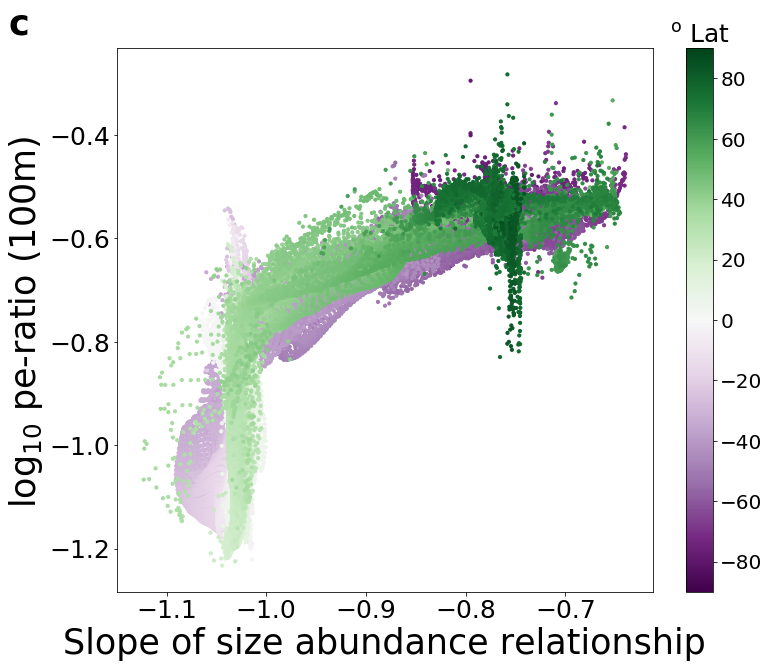

In [28]:
fig = plt.figure(figsize=(12, 10))
X=np.array(slope_150m)[~np.isnan(np.log10(np.array(pe_ratio)))]
Y=np.log10(np.array(pe_ratio))[~np.isnan(np.log10(np.array(pe_ratio)))]
lat = np.array(ds.TLAT)[~np.isnan(np.log10(np.array(pe_ratio)))]

z = lat
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='PRGn')
slope, intercept, r_value, p_value, std_err = stats.linregress(x=X,y=Y)
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('Slope of size abundance relationship', fontsize=35)
plt.ylabel('log$_{10}$ pe-ratio (100m) ',fontsize = 35)
fig.text(0, 0.9, 'c',fontsize=35, fontweight='bold')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('$^o$ Lat',fontsize=25)
plt.clim(-90, 90) 
#fig.text(0.15, 0.84, 'y ='+'{0:1.3g}'.format(slope)+'x +'+'{0:1.3g}'.format(intercept)+'',fontsize=25)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/pe_ratio_100m_20yrclim.png',dpi=600, bbox_inches='tight')

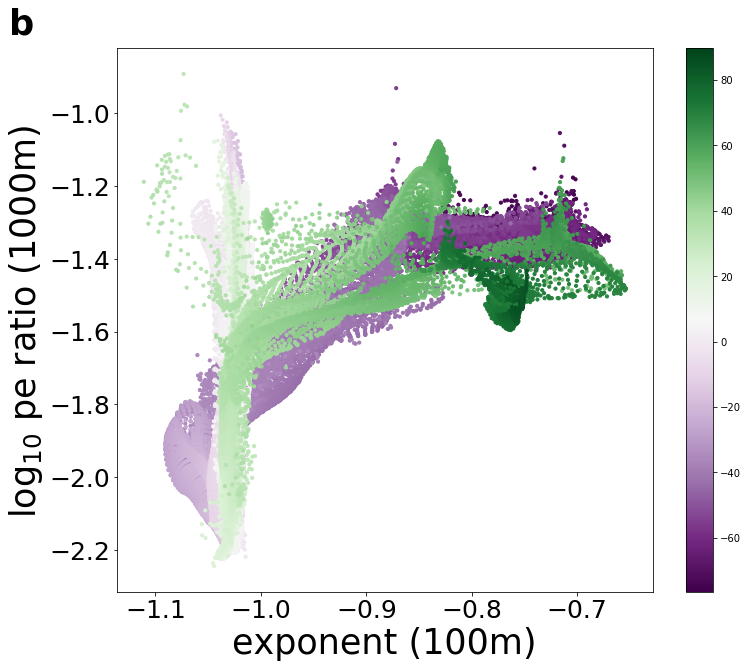

In [29]:
fig = plt.figure(figsize=(12, 10))
X=np.array(slope_150m)[~np.isnan(np.log10(np.array(pe_ratio_1000m)))]
Y=np.log10(np.array(pe_ratio_1000m))[~np.isnan(np.log10(np.array(pe_ratio_1000m)))]
lat = np.array(ds.TLAT)[~np.isnan(np.log10(np.array(pe_ratio_1000m)))]

z = lat
plt.scatter(y=Y,x=X, c=z,s=10, alpha=1,cmap='PRGn')
slope, intercept, r_value, p_value, std_err = stats.linregress(x=X,y=Y)
fig.text(0, 0.9, 'b',fontsize=35, fontweight='bold')
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('exponent (100m)', fontsize=35)
cb.ax.set_title('$^o$ Lat',fontsize=25)
plt.ylabel('log$_{10}$ pe ratio (1000m) ',fontsize = 35)
plt.colorbar()